<img style="float: left;" src="images/EP_Logo.png" alt="UoE" width="300px"/>
<img style="float: right;" src="images/UoE_Logo.png" alt="UoE" width="300px"/>
<img style="float: center;" src="images/urban_rural_scape.png" alt="urban" width="1100px"/>

# Modelling emissions from road traffic
<img style="float: right;" src="images/car-exhaust.png" alt="smoky car" width="240px"/></p>
 
Jupyter notebook for ECSC09005 Environmental Pollution  
author: John Moncrieff *for* Session 2020-21  [version 0.14, latest 11:06, 1 Feb 2021]
## Background
Modelling polutant dispersal from fixed point and area sources by the gaussian plume model is obvious but how do we model vehicle emissions from traffic flowing along a road? We just adapt the gaussian plume model by effectively replicating point sources along the roadway and running individual gaussian plume models at each of these points. This is known as a line source model. In this exercise, we will use a line source model called *RLine* from  the US Environmnental Protection Agency. This model has been well used for many years and is used for all sorts of regulatory purposes in the USA. You can read more about RLine at the US EPA's web site - https://www.cmascenter.org/r-line/. You used the UK's DMRB screening model to look at traffic emissions; RLINE is a step up in complexity and realism.

What I want you to get out of RLine is an appreciation for how emissions from the vehicle fleet is influenced by wind speed, atmospheric stability and wind direction and how that dictates local air quality.

## Imports
Let's start by importing some libraries to the environment:
- *matplotlib inline* for creating inline plots
- *pandas* to order and sort data in a convenient Table-like format
- *numpy* for numerical routines
- *matplotlib* for plotting data
- *scipy* for interploation routines
- *tqdm* for timing progress bar 
- *subprocess* so we can run RLine which is written in FORTRAN
- *ipywidgets* for interactivity
- *defins* for python code that just takes up space in the main notebook

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
import sys
import math
import tqdm as tqdm
import subprocess
import os
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import HBox, Label
from src import efbvt, pls, plm
print('Imports loaded - continue')

Imports loaded - continue


## Step 1: Get the emissions inventory

As we discussed in the lecture series, we need 3 pieces of information to perform a dispersion modelling exercise: weather conditions, an emissions inventory and a dispersion model. In this exercise, we'll just assume 4 different atmospheric stabilities and use a dispersion model called RLINE which models emissions from traffic. The emissions inventory we will use is derived from vehicle tests under different traffic scenarios and on different road types. It can get a bit complicated to come up with vehicle emissions that are then fed into the dispersion model. We use a methodology which has been well-documented (eg.  ). I'll give you a flavour of what is involved but the detail can be a bit overwhelming - quite often users use an Excel-based system called the 'Emissions Factor Toolkit' but we've found that this no longer seems to be compatible with macs in particular so I've coded it up into python for this exercise (my python code is imported here but if you want to view it, its in the file you downloaded from GitHub).

The total emission factors ($EF_i$) and traffic activity ($A_i$) inputs are combined to create hourly emissions, ($E_i$) for each roadlink ($i$) in the area we are modelling.
$E_i = EF_i \ A_i$
< where:  
$E F_i = \sum_{vehclass} e \ f_i (pollutant, speed, month, temp)  fleetmix(vehclass)$  <br>
$A_i = AADT_i \ TAF_i (hour, day, month)$  


The concentration ($C$) at any location is given by $C = \sum_i E_i \ X_i$ where $X_i$ is the dispersion from each road link, $i$ to each receptor generated by RLINE with unit emission rate.

COPERT calculations

Sources of data:
Speed-related emissions of eg NOx and PM: https://naei.beis.gov.uk/data/ef-transport
refers to COPERT calculations which in turn give a generic equation to calculate speed dependent ‘hot’ emission factors in g/km  (Equation 25 in “1.A.3.b-iv Road transport Oct. 2020.pdf”
        EF=(AlphaxV2 +BetaxV+Gamma+Delta/V)/(EpsilonxV2 +ZetaxV+Eta)x(1-RF) 
where the Alphas, Betas etc are given in an accompanying spreadsheet for MANY vehicle types 
see “1.A.3.b.i-iv Road Transport Appendix 4 Emission Factors_2020Sept.xlsx”

$EF = \Large \frac{(\alpha v^2 + \beta v + \gamma + \delta /v)}{(\epsilon v^2 + \zeta v + \eta)} \large (1-RF)$

<details>  
<summary markdown="span">Example vehicle data, click to expand</summary>
    
<div class="alert alert-block alert-info">
    
|    Category    |  Fuel  |       Segment       | Euro Standard | Technology |  Pollutant |      Mode      | Min Speed [km/h] | Max Speed [km/h] |    Alpha   |    Beta    |    Gamma   |    Delta   |   Epsilon  |    Zita    |     Hta    | Reduction Factor [%] | Bio Reduction Factor [%] | 15 | EF [g/km] or ECF [MJ/km] |
|:--------------:|:------:|:-------------------:|:-------------:|:----------:|:----------:|:--------------:|:----------------:|:----------------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:--------------------:|:------------------------:|:--:|:------------------------:|
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 4        | GDI        | PM Exhaust | Urban Peak     | 10               | 130              | 0          | 0          | 0.00128    | 0          | 0          | 0          | 1          | 0                    | 0                        | 15 | 0.00128                  |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 4        | GDI        | PM Exhaust | Urban Off Peak | 10               | 130              | 0          | 0          | 0.00128    | 0          | 0          | 0          | 1          | 0                    | 0                        | 15 | 0.00128                  |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 4        | GDI        | PM Exhaust | Rural          | 10               | 130              | 0          | 0          | 0.000836   | 0          | 0          | 0          | 1          | 0                    | 0                        | 15 | 0.000836                 |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 4        | GDI        | PM Exhaust | Highway        | 10               | 130              | 0          | 0          | 0.00119    | 0          | 0          | 0          | 1          | 0                    | 0                        | 15 | 0.00119                  |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 4        | PFI        | PM Exhaust | Urban Peak     | 10               | 130              | 0          | 0          | 0.00128    | 0          | 0          | 0          | 1          | 0                    | 0                        | 15 | 0.00128                  |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 4        | PFI        | PM Exhaust | Urban Off Peak | 10               | 130              | 0          | 0          | 0.00128    | 0          | 0          | 0          | 1          | 0                    | 0                        | 15 | 0.00128                  |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 4        | PFI        | PM Exhaust | Rural          | 10               | 130              | 0          | 0          | 0.000836   | 0          | 0          | 0          | 1          | 0                    | 0                        | 15 | 0.000836                 |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 4        | PFI        | PM Exhaust | Highway        | 10               | 130              | 0          | 0          | 0.00119    | 0          | 0          | 0          | 1          | 0                    | 0                        | 15 | 0.00119                  |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 5        | GDI        | PM Exhaust |                | 10               | 130              | 5.7274E-07 | -0.0001259 | 0.00690719 | 0.06422941 | 0.00032976 | -0.0877664 | 6.01192129 | 0                    | 0                        | 15 | 0.00197701               |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 5        | PFI        | PM Exhaust |                | 10               | 130              | 5.7274E-07 | -0.0001259 | 0.00690719 | 0.06422941 | 0.00032976 | -0.0877664 | 6.01192129 | 0                    | 0                        | 15 | 0.00197701               |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 6 a/b/c  | GDI        | PM Exhaust |                | 10               | 130              | 7.3573E-07 | -0.0001581 | 0.00928471 | 0.04108643 | 0.00026877 | -0.077925  | 6.02105323 | 0                    | 0                        | 15 | 0.00199838               |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 6 a/b/c  | PFI        | PM Exhaust |                | 10               | 130              | 7.3573E-07 | -0.0001581 | 0.00928471 | 0.04108643 | 0.00026877 | -0.077925  | 6.02105323 | 0                    | 0                        | 15 | 0.00199838               |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 6 d-temp | GDI        | PM Exhaust |                | 10               | 130              | 5.5963E-07 | -0.0001169 | 0.00745951 | 0.00740175 | 9.3328E-05 | -0.0348877 | 3.5051065  | 0.5                  | 0                        | 15 | 0.00105318               |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 6 d-temp | PFI        | PM Exhaust |                | 10               | 130              | 5.5963E-07 | -0.0001169 | 0.00745951 | 0.00740175 | 9.3328E-05 | -0.0348877 | 3.5051065  | 0.5                  | 0                        | 15 | 0.00105318               |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 6 d      | GDI        | PM Exhaust |                | 10               | 130              | 5.5963E-07 | -0.0001169 | 0.00745951 | 0.00740175 | 9.3328E-05 | -0.0348877 | 3.5051065  | 0.5                  | 0                        | 15 | 0.00105318               |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 6 d      | PFI        | PM Exhaust |                | 10               | 130              | 5.5963E-07 | -0.0001169 | 0.00745951 | 0.00740175 | 9.3328E-05 | -0.0348877 | 3.5051065  | 0.5                  | 0                        | 15 | 0.00105318               |
| Passenger Cars | Diesel | Large-SUV-Executive | Euro 4        | DPF        | PM Exhaust |                | 10               | 130              | 1.1723E-05 | -0.0018157 | 0.15159145 | 2.443E-14  | -4.455E-18 | -3.28E-15  | 3.36869884 | 0                    | 0                        | 15 | 0.037698                 |
| Passenger Cars | Diesel | Large-SUV-Executive | Euro 5        | DPF        | PM Exhaust |                | 10               | 130              | -2.689E-07 | 7.5661E-05 | 0.02388406 | 0.08265939 | -0.000608  | 0.21145386 | 4.45558199 | 0                    | 0                        | 15 | 0.00406765               |
| Passenger Cars | Diesel | Large-SUV-Executive | Euro 6 a/b/c  | DPF        | PM Exhaust |                | 10               | 130              | 0.0004673  | 0.0664095  | -0.3250106 | 0.96076264 | 1.13723866 | 0.54617955 | 0.28963315 | 0                    | 0                        | 15 | 0.0031787                |
| Passenger Cars | Diesel | Large-SUV-Executive | Euro 6 d-temp | DPF        | PM Exhaust |                | 10               | 130              | 0.0004673  | 0.0664095  | -0.3250106 | 0.96076264 | 1.13723866 | 0.54617955 | 0.28963315 | 0                    | 0                        | 15 | 0.0031787                |
| Passenger Cars | Diesel | Large-SUV-Executive | Euro 6 d      | DPF        | PM Exhaust |                | 10               | 130              | 0.0004673  | 0.0664095  | -0.3250106 | 0.96076264 | 1.13723866 | 0.54617955 | 0.28963315 | 0                    | 0                        | 15 | 0.0031787                |
    </div>  
 </details>

Testing vehicles for emissions is a regular part of motor manufacturing and maintenance. While some of it has a dodgy past (think dieselgate from VW https://www.telegraph.co.uk/finance/newsbysector/industry/11906842/Five-questions-about-the-VW-emissions-scandal-that-wont-go-away.html), there are more safeguards in place now. This is quite a nice read from a personal viewpoint by one 'concerned BBC journalist': https://www.bbc.co.uk/news/resources/idt-sh/how_toxic_is_your_car_exhaust
<img style="float: right;" src="images/mira.png" alt="emissions testing" width="360px"/></p>

In [2]:
# Should now scale for the time of day effect
# TAF - Temporal Allocation Factor
#  Get from up-to-date Tom Tom web site: 
#      https://www.tomtom.com/en_gb/traffic-index/edinburgh-traffic/
#  For a typical Wednesday since that seems to be the eveing rush-hour with most congestion
# TAF list has % congestion by hour starting at hour 0, midnight
# In Jupyter Notebook make this a Figure
TomTom_congestion = [2, 0, 0, 0, 0, 0, 13, 54, 80, 50, 38, 38, 40, \
        40, 42, 55, 81, 86, 54, 30, 20, 16, 14, 8]
#print(sum(TomTom_congestion))
trafficstats = {"AADT": 10000,
                "hour": 12,
                "vs": 15
               }
# Now adjust for fleet Mix and AADT and Time
# Defaults -  get from spreadsheet for 2020
# Urban split for England in 2020 below since that's likely to be the most relevant
# Use a selection box for this
fleetmix_2020 = {"electric": 0.5, 
                 "petrol": 47.8, 
                 "diesel":33.1,
                 "petrol_lgv": 0.4,
                 "diesel_lgv": 15.0,
                 "rigid": 0.9,
                 "artic": 0.4,
                 "biodiesel": 0.1,
                 "buses": 0.7,
                 "motorcycle": 1.1
                }
sumt=0.0
for x in fleetmix_2020.values():
  sumt=sumt+x
sumtt=(str(int(sumt)))
print(sumtt)

100


In [3]:
# All this to go into separate python code to be imported
bft_electric = widgets.BoundedFloatText(value = fleetmix_2020["electric"], min=0.1, max=90, step=1, 
                                     description="electric %", width=50)
bft_petrol_cars = widgets.BoundedFloatText(value = fleetmix_2020["petrol"], min=5, max=75, step=0.5, 
                                        description="petrol cars %", width=50)
bft_diesel_cars = widgets.BoundedFloatText(value =fleetmix_2020["diesel"],  min=5, max=75, step=0.5, 
                                        description="diesel cars %", width=50)
bft_petrol_lgv = widgets.BoundedFloatText(value =fleetmix_2020["petrol_lgv"], min=0.1, max=0.8, step=0.1, 
                                       description="petrol lgv %", width=50)
bft_diesel_lgv = widgets.BoundedFloatText(value=fleetmix_2020["diesel_lgv"], min=3, max=18, step=1, 
                                       description="diesel lgv %", width=50)
bft_rigid_truck = widgets.BoundedFloatText(value=fleetmix_2020["rigid"],min=0.1, max=1.0, step=0.1, 
                                        description="rigid truck %", width=50)
bft_artic_truck = widgets.BoundedFloatText(value=fleetmix_2020["artic"], min=0.1, max=0.6, step=0.1, 
                                        description="artic truck %", width=50)  
bft_biodiesel = widgets.BoundedFloatText(value=fleetmix_2020["biodiesel"], min=0.1, max=1.0,step=0.1, 
                                      description="biodiesel %", width=50)
bft_buses = widgets.BoundedFloatText(value=fleetmix_2020["buses"], min=0.1, max=1.5, step=0.1, 
                                  description="buses %", width=50)
bft_motorcycles = widgets.BoundedFloatText(value=fleetmix_2020["motorcycle"], min=0.5, max=1.5, step=0.1, 
                                        description="motorcycles %", width=50)
sumtotal = widgets.Text(value=sumtt,description="Total should be 100%", width=50, color='red')

def checksum():
    sum=0.0
    for x in fleetmix_2020.values():
        sum=sum+x
    sumt=sum
    sumtt=(str(int(sumt))) # make it an integer so students don't chase getting exactly 100.0
    sumtotal.value = sumtt   
def bft_electric_eventhandler(change):
    bft_electric.observe(bft_electric_eventhandler, names='value')
    fleetmix_2020["electric"]=bft_electric.value
    checksum()
def bft_petrol_cars_eventhandler(change):
    bft_petrol_cars.observe(bft_petrol_cars_eventhandler, names='value')
    fleetmix_2020["petrol"]=bft_petrol_cars.value
    checksum()
def bft_diesel_cars_eventhandler(change):
    bft_diesel_cars.observe(bft_diesel_cars_eventhandler, names='value')
    fleetmix_2020["diesel"]=bft_diesel_cars.value
    checksum()
def bft_petrol_lgv_eventhandler(change):
    bft_petrol_lgv.observe(bft_petrol_lgv_eventhandler, names='value')
    fleetmix_2020["petrol_lgv"]=bft_petrol_lgv.value
    checksum()
def bft_diesel_lgv_eventhandler(change):
    bft_diesel_lgv.observe(bft_diesel_lgv_eventhandler, names='value')
    fleetmix_2020["diesel_lgv"]=bft_diesel_lgv.value
    checksum()
def bft_rigid_truck_eventhandler(change):
    bft_rigid_truck.observe(bft_rigid_truck_eventhandler, names='value')
    fleetmix_2020["rigid"]=bft_rigid_truck.value
    checksum()
def bft_artic_truck_eventhandler(change):
    bft_artic_truck.observe(bft_artic_truck_eventhandler, names='value')
    fleetmix_2020["artic"]=bft_artic_truck.value
    checksum()
def bft_biodiesel_eventhandler(change):
    bft_biodiesel.observe(bft_biodiesel_eventhandler, names='value')
    fleetmix_2020["biodiesel"]=bft_biodiesel.value
    checksum()
def bft_buses_eventhandler(change):
    bft_buses.observe(bft_buses_eventhandler, names='value')
    fleetmix_2020["buses"]=bft_buses.value
    checksum()
def bft_motorcycles_eventhandler(change):
    bft_motorcycles.observe(bft_motorcycles_eventhandler, names='value')
    fleetmix_2020["motorcycle"]=bft_motorcycles.value
    checksum()

#sumtotal.observe(sumtotal_eventhandler, names='value')
bft_electric.observe(bft_electric_eventhandler, names='value')
bft_petrol_cars.observe(bft_petrol_cars_eventhandler, names='value')
bft_diesel_cars.observe(bft_diesel_cars_eventhandler, names='value')
bft_petrol_lgv.observe(bft_petrol_lgv_eventhandler, names='value')
bft_diesel_lgv.observe(bft_diesel_lgv_eventhandler, names='value')
bft_rigid_truck.observe(bft_rigid_truck_eventhandler, names='value')
bft_artic_truck.observe(bft_artic_truck_eventhandler, names='value')
bft_biodiesel.observe(bft_biodiesel_eventhandler, names='value')
bft_buses.observe(bft_buses_eventhandler, names='value')
bft_motorcycles.observe(bft_motorcycles_eventhandler, names='value')

h1 = widgets.HBox(children=[bft_electric, bft_petrol_cars, bft_diesel_cars])
h2 = widgets.HBox(children=[bft_petrol_lgv, bft_diesel_lgv, bft_rigid_truck])
h3 = widgets.HBox(children=[bft_artic_truck, bft_biodiesel, bft_buses])
h4 = widgets.HBox(children=[bft_motorcycles,sumtotal])

widgets.VBox(children=[h1,h2,h3,h4])


In [4]:
# Check totals add up to 100% or near 100%

print(fleetmix_2020)
sum=0.0
for x in fleetmix_2020.values():
  sum=sum+x
print(sum)

{'electric': 0.5, 'petrol': 47.8, 'diesel': 33.1, 'petrol_lgv': 0.4, 'diesel_lgv': 15.0, 'rigid': 0.9, 'artic': 0.4, 'biodiesel': 0.1, 'buses': 0.7, 'motorcycle': 1.1}
100.00000000000001


In [5]:
bft_hour = widgets.BoundedIntText(value=trafficstats["hour"],min=1, max=24, step=1,
                                    description="Hour of Day")
bft_AADT = widgets.BoundedIntText(value=trafficstats["AADT"], min=1000, max=55000,step=1000,
                                    description="AADT")
bft_vs = widgets.BoundedIntText(value=trafficstats["vs"], min=5, max=85, step=5,
                                  description="Speed")

def bft_hour_eventhandler(change):
    bft_hour.observe(bft_hour_eventhandler, names='value')
    trafficstats["hour"]=bft_hour.value
def bft_AADT_eventhandler(change):
    bft_AADT.observe(bft_AADT_eventhandler, names='value')
    trafficstats["AADT"]=bft_AADT.value
def bft_vs_eventhandler(change):
    bft_vs.observe(bft_vs_eventhandler, names='value')
    trafficstats["vs"]=bft_vs.value
    
bft_hour.observe(bft_hour_eventhandler, names='value')
bft_AADT.observe(bft_AADT_eventhandler, names='value')
bft_vs.observe(bft_vs_eventhandler, names='value')
    
input_widgets = widgets.HBox([bft_AADT, bft_vs, bft_hour])
display(input_widgets)

In [6]:
# This cell actually calculates the emission inventory for any road taking
# into account the % type of vehicles in the mix, the congestion,
# traffic count, hour of day and average vehicle speed.
hwpme,hwnxe,traffic_count = efbvt.efbvt(fleetmix_2020, trafficstats, TomTom_congestion)
# returns PM and NOx emission in units of g/m/s ready for input to RLINE
# It does take a few seconds to run so be patient. 
# You'll see 3 lines of text output when the cell completes

10000 15 12
PM Emission (g/m/s) =  [1.44303544e-05]
NOx Emission (g/m/s) =  [0.00027263]


In [7]:
print("Click to run RLINE with the folllowing inputs: ",trafficstats)
print("It'll take a few seconds to run then you'll see a message to proceed to the next cell")
btn = widgets.Button(description='Run RLINE', width=100)
btn.style.button_color = 'tomato'
display(btn)
def btn_eventhandler(obj):
    if not os.path.exists("Line_Source_Inputs.txt"):
        print("File does not exist: "+str('Line_Source_Inputs.txt'))
    if not os.path.exists("Receptor_Example.txt"):
        print("File does not exist: "+str("Receptor_Example.txt"))    
    if not os.path.exists("Source_Example.txt"):
        print("File does not exist: "+str("Source_Example.txt"))
    if not os.path.exists("Met_Example.sfc"):
        print("File does not exist: "+str("Met_Example.sfc"))
    # Delete any old data before running the model again
    ## delete only if file exists ##
    if os.path.exists("RLINEv1_2_gfortran_mac.exe"):
        #ret = subprocess.run(["./RLINEv1_2.ifort.x"],shell=True)
        print("running RLINE ...")
        ret = subprocess.call(["./RLINEv1_2_gfortran_mac.exe"],shell=True)
    else:
        sys.exit(0)
    if(ret == 0):
        print("Run complete - goto next cell")

btn.on_click(btn_eventhandler)

Click to run RLINE with the folllowing inputs:  {'AADT': 10000, 'hour': 12, 'vs': 15}
It'll take a few seconds to run then you'll see a message to proceed to the next cell


Button(description='Run RLINE', style=ButtonStyle(button_color='tomato'))

running RLINE ...
Run complete - goto next cell


In [8]:
sites = []
max = min = 0
gs = gridspec.GridSpec(4, 4)
gs.update(left=0.10, right=0.95, hspace=0.05)
hourly_stab = ['stable','weakly stable','weakly convective','convective']

infilename = 'Output_Example_Numerical.csv'
infilename2 = 'Met_Example.csv'   
# use Pandas to read in concentration data
dfc=pd.read_csv("Output_Example_Numerical.csv", header=10, skipinitialspace=True)

# NB - RLINE has calculated the concentrations based on unit emission
# so we need to multiply the predicted concentrations by the actual emissions
hourlist=[]
# Split into hourly dataframes for graphing
# https://stackoverflow.com/questions/54046707/pandas-split-one-dataframe-into-multiple-dataframes
for h in dfc['Hour'].unique():
    temp = 'dfc_{}'.format(h)
    hourlist.append(temp)  # keep track of data files to process
    vars()[temp] = dfc[dfc['Hour']==h]
hourlist=[dfc_1, dfc_2, dfc_3, dfc_4]
#dfc_1.head(5)
#dfc_2.head(5)
dfc_3.head(5)
print(hourlist)

[     Year  Julian_Day  Hour  X-Coordinate  Y-Coordinate  Z-Coordinate  \
0      12         264     1          10.0          10.0           1.5   
1      12         264     1          10.0          20.0           1.5   
2      12         264     1          10.0          30.0           1.5   
3      12         264     1          10.0          40.0           1.5   
4      12         264     1          10.0          50.0           1.5   
..    ...         ...   ...           ...           ...           ...   
191    12         264     1        -100.0         -30.0           1.5   
192    12         264     1        -100.0         -40.0           1.5   
193    12         264     1        -100.0         -50.0           1.5   
194    12         264     1        -100.0         -75.0           1.5   
195    12         264     1        -100.0        -100.0           1.5   

          C_G1       C_G2  Unnamed: 8  
0    2043070.0  2042370.0         NaN  
1    2043230.0  1824570.0         NaN  
2 

[1.44303544e-05]
[0.00027263]
     Year  Julian_Day  Hour  X-Coordinate  Y-Coordinate  Z-Coordinate  \
0      12         264     1          10.0          10.0           1.5   
1      12         264     1          10.0          20.0           1.5   
2      12         264     1          10.0          30.0           1.5   
3      12         264     1          10.0          40.0           1.5   
4      12         264     1          10.0          50.0           1.5   
..    ...         ...   ...           ...           ...           ...   
191    12         264     1        -100.0         -30.0           1.5   
192    12         264     1        -100.0         -40.0           1.5   
193    12         264     1        -100.0         -50.0           1.5   
194    12         264     1        -100.0         -75.0           1.5   
195    12         264     1        -100.0        -100.0           1.5   

          C_G1       C_G2  Unnamed: 8  
0    2043070.0  2042370.0         NaN  
1    2043230.

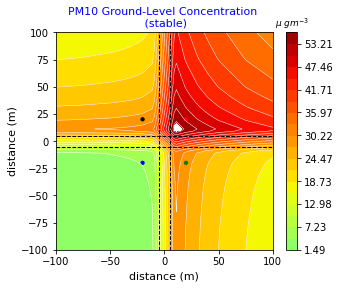

     Year  Julian_Day  Hour  X-Coordinate  Y-Coordinate  Z-Coordinate  \
196    12         264     2          10.0          10.0           1.5   
197    12         264     2          10.0          20.0           1.5   
198    12         264     2          10.0          30.0           1.5   
199    12         264     2          10.0          40.0           1.5   
200    12         264     2          10.0          50.0           1.5   
..    ...         ...   ...           ...           ...           ...   
387    12         264     2        -100.0         -30.0           1.5   
388    12         264     2        -100.0         -40.0           1.5   
389    12         264     2        -100.0         -50.0           1.5   
390    12         264     2        -100.0         -75.0           1.5   
391    12         264     2        -100.0        -100.0           1.5   

         C_G1      C_G2  Unnamed: 8  
196  791078.0  790980.0         NaN  
197  791038.0  648053.0         NaN  
198  7910

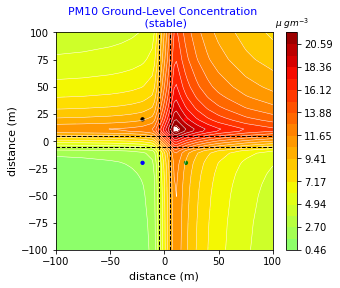

     Year  Julian_Day  Hour  X-Coordinate  Y-Coordinate  Z-Coordinate  \
392    12         264     3          10.0          10.0           1.5   
393    12         264     3          10.0          20.0           1.5   
394    12         264     3          10.0          30.0           1.5   
395    12         264     3          10.0          40.0           1.5   
396    12         264     3          10.0          50.0           1.5   
..    ...         ...   ...           ...           ...           ...   
583    12         264     3        -100.0         -30.0           1.5   
584    12         264     3        -100.0         -40.0           1.5   
585    12         264     3        -100.0         -50.0           1.5   
586    12         264     3        -100.0         -75.0           1.5   
587    12         264     3        -100.0        -100.0           1.5   

           C_G1        C_G2  Unnamed: 8  
392  1006170.00  1006140.00         NaN  
393  1006200.00   604012.00         NaN

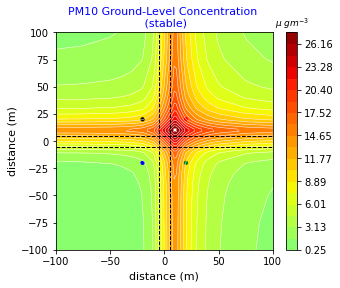

     Year  Julian_Day  Hour  X-Coordinate  Y-Coordinate  Z-Coordinate  \
588    12         264     4          10.0          10.0           1.5   
589    12         264     4          10.0          20.0           1.5   
590    12         264     4          10.0          30.0           1.5   
591    12         264     4          10.0          40.0           1.5   
592    12         264     4          10.0          50.0           1.5   
..    ...         ...   ...           ...           ...           ...   
779    12         264     4        -100.0         -30.0           1.5   
780    12         264     4        -100.0         -40.0           1.5   
781    12         264     4        -100.0         -50.0           1.5   
782    12         264     4        -100.0         -75.0           1.5   
783    12         264     4        -100.0        -100.0           1.5   

          C_G1       C_G2  Unnamed: 8  
588  312448.00  312470.00         NaN  
589  312417.00  239433.00         NaN  
590

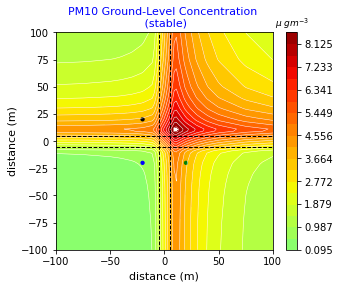

In [11]:
# extract the x, y, z-values to 1-D arrays for plotting
xx = dfc_1['X-Coordinate'].to_numpy()
yy = dfc_1['Y-Coordinate'].to_numpy()
print(hwpme)
print(hwnxe)  
for dfhn in hourlist:
    dfh = pd.DataFrame(dfhn)
    print(dfh)
    # Particulate matter
    zzp = (dfh['C_G1']*hwpme+dfh['C_G2']*hwpme).to_numpy()
    # NOx
    zzn = (dfh['C_G1']*hwnxe+dfh['C_G2']*hwnxe).to_numpy()

    max = (dfh['C_G1']*hwpme+dfh['C_G2']*hwpme).max()
    min = (dfh['C_G1']*hwpme+dfh['C_G2']*hwpme).min()

    # get the concentration values at the 4 receptor sites
    dfs1 = dfh[((dfh['X-Coordinate'] == 20.000) & (dfh['Y-Coordinate'] == 20.000))]
    dfs2 = dfh[((dfh['X-Coordinate'] == 20.000) & (dfh['Y-Coordinate'] == -20.000))]
    dfs3 = dfh[((dfh['X-Coordinate'] == -20.000) & (dfh['Y-Coordinate'] == -20.000))]
    dfs4 = dfh[((dfh['X-Coordinate'] == -20.000) & (dfh['Y-Coordinate'] == 20.000))]

    s1z = dfs1.iloc[0]['C_G1']*hwpme+dfs1.iloc[0]['C_G2']*hwpme
    s2z = dfs2.iloc[0]['C_G1']*hwpme+dfs2.iloc[0]['C_G2']*hwpme
    s3z = dfs3.iloc[0]['C_G1']*hwpme+dfs3.iloc[0]['C_G2']*hwpme
    s4z = dfs4.iloc[0]['C_G1']*hwpme+dfs4.iloc[0]['C_G2']*hwpme

    sites = [s1z, s2z, s3z, s4z]
    # pass to plotting routine
    pls.pls(gs, xx, yy, zzp, 1, min, max, hourly_stab)
    
# use Pandas to read in meteorology data
dfm=pd.read_csv("Met_Example.csv", skip_blank_lines=True, skipinitialspace=True)
#dfm.head(4)

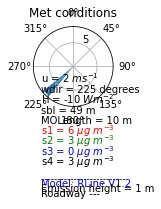

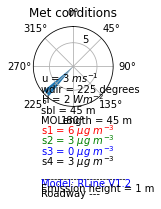

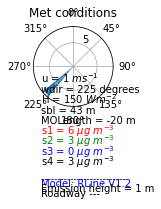

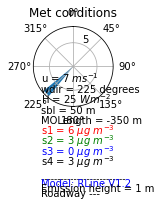

In [12]:
for h in dfm['Hour'].unique():
    temp = 'dfm_{}'.format(h)    
    vars()[temp] = dfm[dfm['Hour']==h]
    plm.plm(gs, vars()[temp], sites)
#----------------------------------------------------------------------

<img style="float: center;" src="images/urban_rural_scape.png" alt="urban" width="1100px"/>

# END